In [ ]:
#data collection
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!head -50 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 118

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#data spliting in 3 subsets
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples

)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [ ]:
#data input pipelining
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [ ]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
#character maping
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
#img resizing
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image




![](https://i.imgur.com/eqq3s4N.png)



In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [ ]:
#tf.data prepare
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

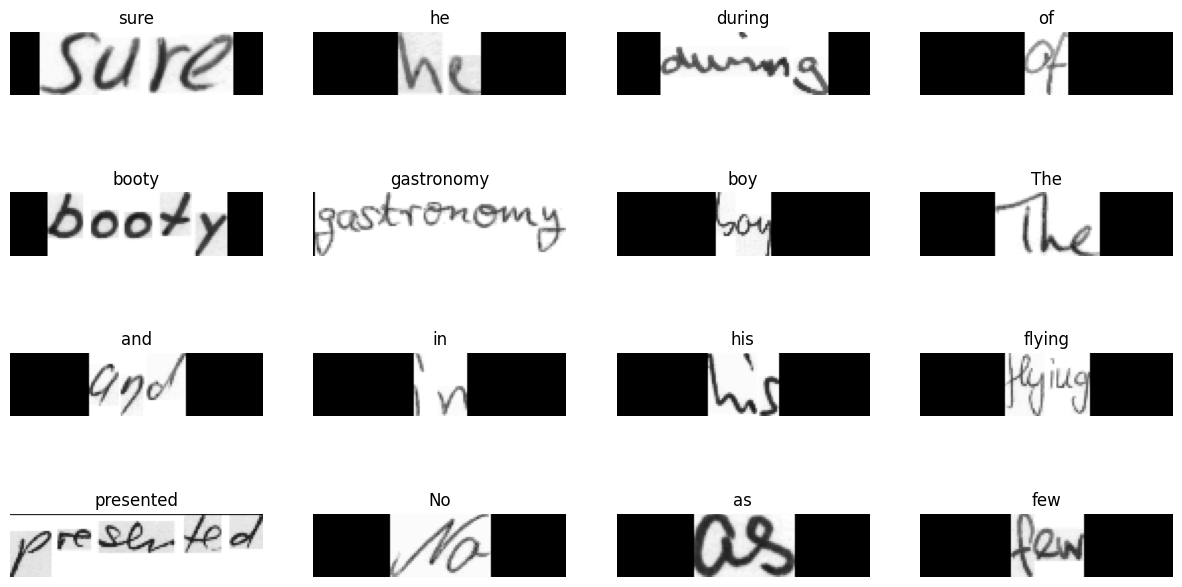

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:
#model
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        return y_pred


def build_model():

    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)



    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

    x = keras.layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = keras.layers.Conv2D(
        1024,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv8",
    )(x)

    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv7",
    )(x)

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(1024, return_sequences=True, dropout=0.2)
    )(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 Conv4 (Conv2D)              (None, 128, 32, 128)         36992     ['Conv1[0][0]']               
                                                                                                  
 Conv6 (Conv2D)              (None, 128, 32, 256)         295168    ['Conv4[0][0]']               
                                                                             

In [ ]:
#segregate labels & image
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:
#callback
def calculate_edit_distance(labels, predictions):

    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [ ]:
#Train the model

epochs = 5 # 60 epoch

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/5
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 19.8309
1357/1357 [==============================] - 371s 254ms/step - loss: 11.5670 - val_loss: 8.1860
Epoch 2/5
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 2: 17.7620
1357/1357 [==============================] - 325s 240ms/step - loss: 5.2958 - val_loss: 2.9560
Epoch 3/5
1/1 [==============================] - 0s 56ms/step
Mean edit distance for epoch 3: 17.4935
1357/1357 [==============================] - 324s 238ms/step - loss: 2.7281 - val_loss: 2.1471
Epoch 4/5
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 4: 17.4235
1357/1357 [==============================] - 323s 238ms/step - loss: 2.0186 - val_loss: 1.9104
Epoch 5/5
1/1 [==============================] - 0s 60ms/step
Mean edit distance for epoch 5: 17.3301
1357/1357 [==============================] - 327s 241ms/step - loss: 1.6583 - val_loss: 1.6957


len is :  2
batch img shape:  (128, 32, 1)
2/2 [==============================] - 0s 54ms/step
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)


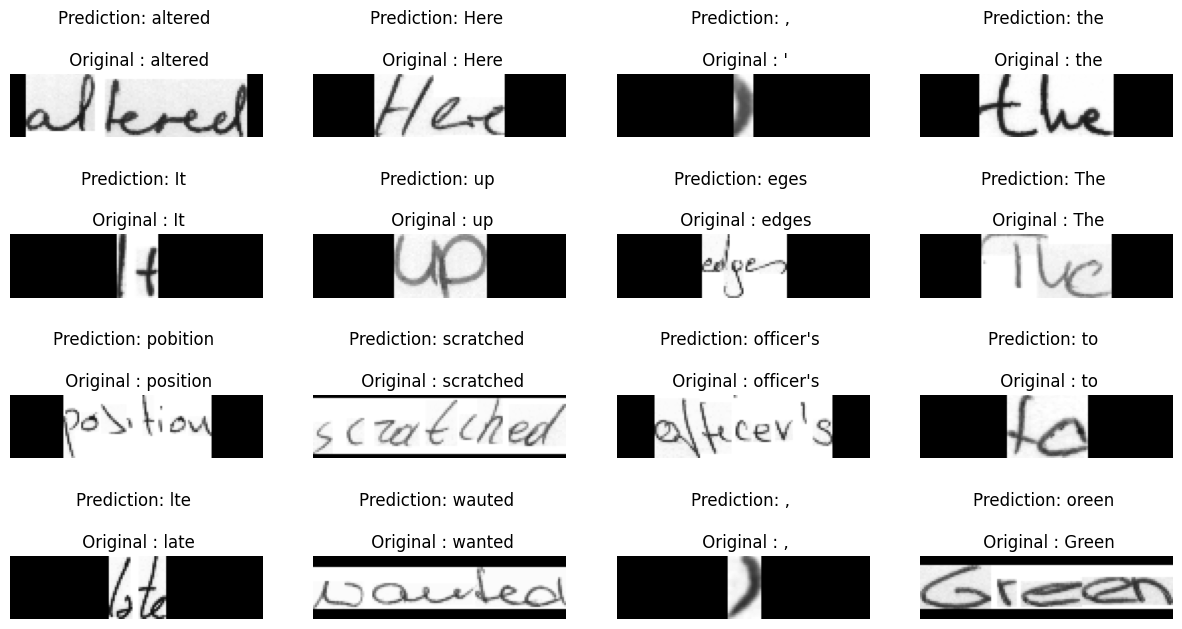

In [ ]:
#Inference
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
for batch in test_ds.take(1):

    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        print(img.shape)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        #string conversions
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()




In [ ]:
# Accuracy

total_count = 0
correct_count = 0

for batch in test_ds.take(75):
    batch_images,batch_labels = batch["image"],batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(64):
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")


        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        total_count = total_count+1
        if(label == pred_texts[i]):
          correct_count = correct_count+1


print("Total count : ",total_count)

print("Correct count : ",correct_count)

percentage = (correct_count/total_count)*100
print(f"Percentage : {percentage}% .")


2/2 [==============================] - 0s 40ms/step
Total count :  4800
Correct count :  3513
Percentage : 73.1875% .


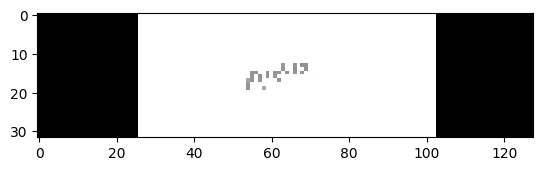

(32, 128)


In [ ]:
img_path = "/content/drive/My Drive/Doctor-Handwriting-Recognition/dataset/medical_5801.jpg"
image2 = preprocess_image(img_path)
# label = vectorize_label(label)
img2 = tf.image.flip_left_right(image2)
img2 = tf.transpose(img2, perm=[1, 0, 2])
img2 = (img2 * 255.0).numpy().clip(0, 255).astype(np.uint8)
img2 = img2[:, :, 0]
plt.imshow(img2,cmap="gray")
plt.show()
img_list = [img2]
print(img2.shape)

In [ ]:

def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [ ]:
img_paths_3 = ["/content/data/words/r03/r03-053/r03-053-01-01.png","/content/data/words/r03/r03-065/r03-065-01-03.png","/content/data/words/r03/r03-090/r03-090-02-04.png","/content/data/words/r03/r03-090/r03-090-06-01.png"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

len is :  4
batch img shape:  (128, 32, 1)
batch img shape:  (128, 32, 1)
1/1 [==============================] - 1s 742ms/step
['grey', 'what', 'ears', 'with']


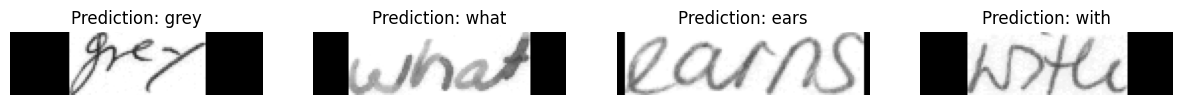

In [ ]:
for batch in custom_ds.take(1):

    print("len is : ",len(batch))
    print("batch img shape: ",batch[0].shape)
    print("batch img shape: ",batch[1].shape)

    _, ax = plt.subplots(1, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(4):
        img = batch[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()
